# A Guide to Using `TorchFit`

`TorchFit` is a minimalistic, barebones training-helper for PyTorch that exposes an easy-to-use `fit` method in the style of **fastai** and **Keras**.  It is intended to be easy-to-follow with a tiny footprint and as little bloat as possible. `TorchFit` is particularly well-suited to those new to PyTorch looking to train classifiers. For more complex training scnenarios (e.g., training GANs, multi-node GPU training), [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) is highly recommended.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# some imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# configuration variables
SEED = 42
DEVICE = 'cuda' # change to 'cpu' if training on CPU
BATCH_SIZE = 32

### Define a `DataLoader` for training/validation and a model in PyTorch just as you normally would

Most of the code below is taken directly from some previous version of the [PyTorch MNIST example](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [2]:
# setup DataLoaders for training and validation as you normally would
kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE=='cuda' else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=False, **kwargs)

# define a PyTorch model as you normally would
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net()

# setup the optimizer, loss function, and metrics as you normally would
optimizer = optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
def accuracy(y_true, y_pred):
    return np.mean(y_true.numpy() == np.argmax(y_pred.numpy(), axis=1))

### Wrap Model and Data in a `torchfit.Learner` Object

In [3]:
# setup a torchfit.Learner instance
import torchfit
learner = torchfit.Learner(model, train_loader, val_loader=test_loader, 
                           optimizer=optimizer, loss=loss, metrics=[accuracy], seed=SEED, device='cuda')

### Estimate the Learning Rate Using `learner.find_lr`

We'll examine the plot and choose a learning rate associated with a falling loss. The `find_lr` method is simple a wrapper to the `torch-lr-finder` library by [David Silva](https://github.com/davidtvs).  In this example, we will run the learning rate finder for a larger number of iterations to produce slightly more accurate estimate, but less iterations are generally acceptable, as well.

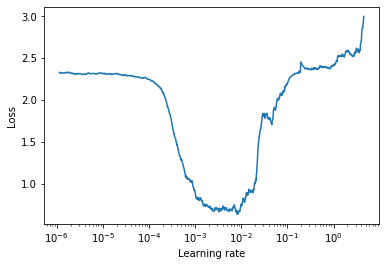

From the plot, select the highest learning rate still associated with a falling loss.


In [4]:
# estimate learning rate
learner.find_lr(num_iter=1500)

We'll select `1e-3` as our maximum learning rate based on the plot.

In [5]:
lr = 1e-3

### Train the Model Using a Learning Rate Scheduler

We'll choose to train for **four epochs**. 
We'll also use the `optim.lr_scheduler.CyclicLR` class in PyTorch to configure a [slanted triangle learning rate policy](https://arxiv.org/pdf/1801.06146.pdf) proposed by Howard and Ruder (2018) and empoyed in the fastai library. It is a variation on [Leslie Smith's 1cycle policy](https://arxiv.org/pdf/1803.09820.pdf).  We'll then go ahead and train using `learner.fit`.

In [6]:
epochs = 4
scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
                                        base_lr=lr/10, 
                                        max_lr=lr, 
                                        cycle_momentum=False, 
                                        step_size_up=epochs*len(train_loader)//3,
                                        step_size_down=epochs*2*len(train_loader)//3)
hist = learner.fit(lr, epochs, schedulers=[scheduler])

Epoch 1 / 4
[========================================] 100%	  loss: 0.7808  accuracy: 0.9553  val_loss: 0.1323  val_accuracy: 0.9593

Epoch 2 / 4
[========================================] 100%	  loss: 0.2982  accuracy: 0.9732  val_loss: 0.0755  val_accuracy: 0.9763

Epoch 3 / 4
[========================================] 100%	  loss: 0.2122  accuracy: 0.9806  val_loss: 0.0569  val_accuracy: 0.9817

Epoch 4 / 4
[========================================] 100%	  loss: 0.1816  accuracy: 0.9829  val_loss: 0.0485  val_accuracy: 0.9847



### Let's plot some training history

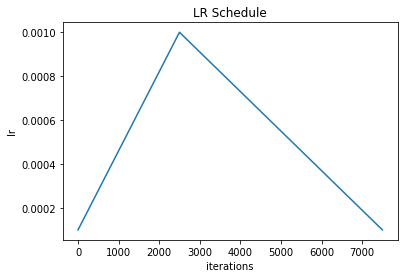

In [7]:
# the slanted learning rate schedule we employed
learner.plot('lr')

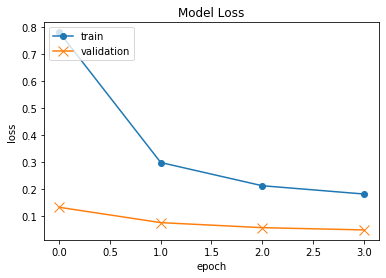

In [8]:
# training loss vs. validation loss
learner.plot('loss')

The validation loss is still decreasing, so we could train further if desired.

### The `fit_onecycle` method

Given that the **slanted triangle** and **1cycle** policies have been shown to be [quite effective](https://arxiv.org/pdf/1803.09820.pdf), `TorchFit` includes a convenience method called `fit_onecycle` that automates the steps above to setup a slanted triangle or 1cycle schedule.  The `start_pct` parameter can control the degree to which the triangle is slanted.  If `start_pct=0.5`, then a **1cycle** policy is generated. Otherwise, a **slanted triangle** policy is generated.

Let's train for two additional epochs using `fit_onecycle` with `start_pct` set to `0.25`.

In [9]:
learner.fit_onecycle(1e-3, 2, start_pct=0.25)

Epoch 1 / 2
[========================================] 100%	  loss: 0.1831  accuracy: 0.9833  val_loss: 0.0488  val_accuracy: 0.9831

Epoch 2 / 2
[========================================] 100%	  loss: 0.1591  accuracy: 0.9857  val_loss: 0.0411  val_accuracy: 0.9874



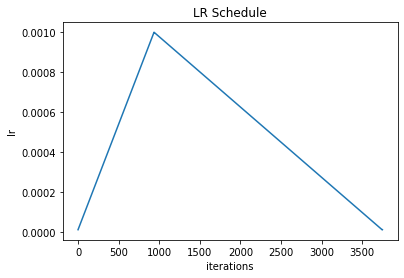

In [10]:
learner.plot('lr')

### Making Predictions on New Data

For illustration purposes, we will simply make predictions on the validation set. We wil generate predictions for the first 10 images in the validation set and compare with ground truth.

In [11]:
# generate prediction using the Learner
y_preds = np.argmax(learner.predict(test_loader), axis=-1)[:10]

#  compile the ground truth labels from first batch
y_true = next(iter(test_loader))[1][:10].cpu().detach().numpy()

# display results
import pandas as pd
pd.DataFrame(zip(y_preds, y_true), columns=['Predicted', 'Actual']).head(10)

,Predicted,Actual
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
5,1,1
6,4,4
7,9,9
8,5,5
9,9,9


### Saving and Restoring Models

We can our model to disk and reload it later in deployment.

In [12]:
learner.save('/tmp/mymodel')

In [13]:
learner.load('/tmp/mymodel')

In [14]:
np.argmax(learner.predict(test_loader), axis=-1)[:5]

array([7, 2, 1, 0, 4])

### Additional Features

The weights of the neural network model can be easily reset using `learner.reset_weights()`. 

`TorchFit` also includes support for **gradient accumulation** and **automatic mixed precision.**